# Univariate testing

In this notebook, we test the following hypothesis:

**White matter tracts have both shared and unique cortical features in structurally connected regions, compared to unconnected regions.**

Approach:

* t-tests comparing cortical features in connected vs unconnected regions.
* Comparison against shuffled tract-to-region probabilities. 
* A significant result would indicate that the surface features linked to this tract are unique, i.e. distinct from surface properties of non-connected brain regions. 



In [1]:
# let's import the needed packages
import pandas as pd
import re
from neuromaps.datasets import fetch_fslr, fetch_annotation
from neuromaps import datasets, images, nulls, resampling, stats, transforms, parcellate
from surfplot import Plot
from neuromaps.parcellate import Parcellater, _gifti_to_array
from neuromaps.resampling import resample_images
from neuromaps.images import dlabel_to_gifti
import neuromaps
import nibabel as nib
import os
import numpy as np
import mayavi
from PIL import Image
import hcp_utils as hcp
import nilearn.plotting as plotting
import tractmaps_utils
import snf
from sklearn import cluster
from snf import metrics
import warnings
warnings.filterwarnings('ignore')

/Users/joelleba/opt/anaconda3/envs/tractmaps/lib/python3.8/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


### Load data
Run the cortical features cell OR the neurosynth cell depending on which maps you want to run analyses on. 

In [2]:
### CORTICAL FEATURES DATA ###
analysis = 'cortex'
data = pd.read_csv('./inputs/tracts_maps_Glasser.csv')

In [2]:
### NEUROSYNTH DATA ###
analysis = 'neurosynth'
data = pd.read_csv('./inputs/tracts_neurosynth_Glasser.csv')

In [3]:
# set up inputs
maps_df = data.iloc[:, 59:]
maps_list = [maps_df[col].values for col in maps_df.columns]
map_names = list(maps_df)
glasser_maps = maps_df.to_dict(orient = 'list')
glasser_maps = {key: np.array(value) for key, value in glasser_maps.items()} # store parcellated maps as dictionary of map_names and arrays

### 3.1 Test tract uniqueness

You might wonder if brain regions that are structurally connected to a given white matter tract might have similar cortical properties. For instance, maybe brain regions connected to the arcuate fasciculus are thicker and have more myelin (totally made up, probably not true!). 

Concretely, we will test the following hypothesis:

**H1. Brain regions that are structurally connected to a tract are more similar than unconnected brain regions.**




#### Case study: zooming into the left arcuate fasciculus

Let's first work with an example. We'll define structurally connected vs non-connected regions for the left arcuate fasciculus, and compare intracortical myelin in connected vs non-connected regions using a two sample, two-tailed t-test. Next, we'll generate a null distribution of this by shuffling parcellated myelin values, yielding a new randomly assigned parcellated myelin map (we keep the same tract-to-region mapping). Then we do the t-test again. We do this 100 times to get a null distribution of differences between the two maps. We can then plot this against the empirically obtained map difference. 
If our hypothesis is correct, then we should find that structurally connected regions have significantly different myelin values compared to non-connected regions. 

##### Step 1: Empirical test comparing map values in connected vs non-connected brain regions

First, let's compute the t-test examining the difference between parcellated myelin values of regions that are structurally connected vs non-connected to the left arcuate fasciculus. 

Note: I wonder if here we should only test against non-connected regions of the **same** hemisphere?

In [4]:
# define map
if analysis == 'cortex':
    case_map = 'myelin_glasser'
elif analysis == 'neurosynth':
    case_map = 'language'

# select brain regions connected to the AF in most people (>95% probability of connection)
left_AF = data.loc[data['AF_left'] > 0.95, ['parcel_name', 'regionLongName', 'cortex', 'regionID']]
# print(f'Number of brain regions structurally connected to the left AF: {len(left_AF)}')

# select brain region indices
left_AF_idx = data.index[data['AF_left'] > 0.95].tolist()

# select all left hemisphere brain region indices
hem_all_idx = data.index[data['parcel_name'].str.contains('L_')].tolist()

# create array with map values of connected brain regions
connected = [glasser_maps[case_map][i] for i in left_AF_idx]
print(f'Number of brain regions structurally connected to the left AF: {len(connected)}')

# create array with map values of non-connected regions
# non_connected = [glasser_maps['myelin_glasser'][i] for i in range(len(myelin_glasser)) if i not in left_AF_idx]

# create array with map values of non-connected regions of the SAME hemisphere as the tract  
non_connected = [glasser_maps[case_map][i] for i in range(len(glasser_maps[case_map])) if i not in left_AF_idx and i in hem_all_idx]
print(f'Number of brain regions NOT structurally connected to the left AF: {len(non_connected)}') 

# two sample two-tailed t-test to compare the difference of the two distributions (structurally connected vs non-connected regions)
from scipy.stats import ttest_ind
from statistics import mean

# In this case we have two sample arrays: structurally connected and non-connected regions
# Perform the t-test
empirical_t_statistic, empirical_p_value = ttest_ind(connected, non_connected)

# compute the difference in the means (will be used for plotting)
empirical_mean_diff = mean(connected) - mean(non_connected)

# Print the results
print("Empirical T-Statistic:", round(empirical_t_statistic, 3))
print("Empirical P-Value:", round(empirical_p_value, 3))
print("Empirical difference in means:", round(empirical_mean_diff, 3))

Number of brain regions structurally connected to the left AF: 20
Number of brain regions NOT structurally connected to the left AF: 160
Empirical T-Statistic: 6.658
Empirical P-Value: 0.0
Empirical difference in means: 4.274


##### Step 2: Generate nulls

The next step is to generate a null distribution for this test by randomly shuffling the parcellated myelin map. Note that when doing significance testing, for non-connected regions we select only regions of the same hemisphere. 

To resolve: based on neuromaps' information, it's unclear whether spinning occurs on one hemisphere (and then gets mirrored on the other hemisphere). There is no 'hemisphere' argument in the `alexander_bloch` function. Here are some details from the Alexander-Bloch et al., 2018 NeuroImage paper: 

"For opposite hemispheres, the same rotations were applied about the left-right axis of rotation, while opposite (negative) rotations were applied about the superior-inferior axis and the anterior-posterior axis, in order to preserve the contralateral symmetry of the rotated maps." - based on this, it seems like it's being mirrored (?).

In [5]:
from scipy.stats import ttest_ind
from statistics import mean

# generate a null distribution by permuting the parcellated map (using neuromaps spatial nulls)
# this gives a new randomly assigned map values (for instance myelin) for each brain region
glasser = tractmaps_utils.get_glasser() # load glasser parcellation GIFTI images (lh, rh)
rotated_maps = nulls.alexander_bloch(glasser_maps[case_map], atlas = 'fsLR', density = '32k',
                                n_perm = 100, seed = 1234, parcellation = glasser)
# print(rotated_maps.shape)
rotated_maps[:,2]

# null result lists
null_t_stats = []
null_p_vals = []
null_mean_diffs = []

# select brain region indices
left_AF_idx = data.index[data['AF_left'] > 0.95].tolist()

# select all left hemisphere brain region indices
hem_all_idx = data.index[data['parcel_name'].str.contains('L_')].tolist()

# loop over permuted brain maps
for map_index, rotated_map in enumerate(rotated_maps.T): # transposing to iterate through columns (i.e. maps)
    
    if map_index < 100: # loop until the 99th iteration, which corresponds to the 100th and last column
        
        # assign the brain regions as connected vs non-connected for each of the 100 permuted maps (columns), except now the map values have been shuffled
        # Note: this is assuming that only the values of the map are shuffled, while the index remains the same
        connected = [rotated_maps[i, map_index] for i in left_AF_idx]
        
        # subset non-connected brain regions
#         non_connected = [rotated_maps[i, map_index] for i in range(len(rotated_maps)) if i not in left_AF_idx]
       
        # subset only non-connected brain regions of the SAME hemisphere as the tract 
        non_connected = [rotated_maps[i, map_index] for i in range(len(rotated_maps)) if i not in left_AF_idx and i in hem_all_idx]
        
#         print(f'Number of brain regions structurally connected to the left AF: {len(connected)}') 
#         print(f'Number of brain regions NOT structurally connected to the left AF: {len(non_connected)}') 

        # two sample two-tailed t-test to compare the difference of the two distributions (structurally connected vs non-connected regions)
        t_statistic, p_value = ttest_ind(connected, non_connected)

        # compute the difference in the means (will be used for plotting)
        mean_diff = mean(connected) - mean(non_connected)

        # print the results
#         print(f'Map number: {map_index}')
#         print("T-Statistic:", round(t_statistic, 3))
#         print("P-Value:", round(p_value, 3))
#         print("Difference in means:", round(mean_diff, 3))

        # save the results
        null_t_stats.append(round(t_statistic, 3))
        null_p_vals.append(round(p_value, 3))
        null_mean_diffs.append(round(mean_diff, 3))

##### Step 3: Visualize the results

Finally, let's plot the null distribution and the empirical result. See figure 2c in this paper: https://elifesciences.org/articles/62116

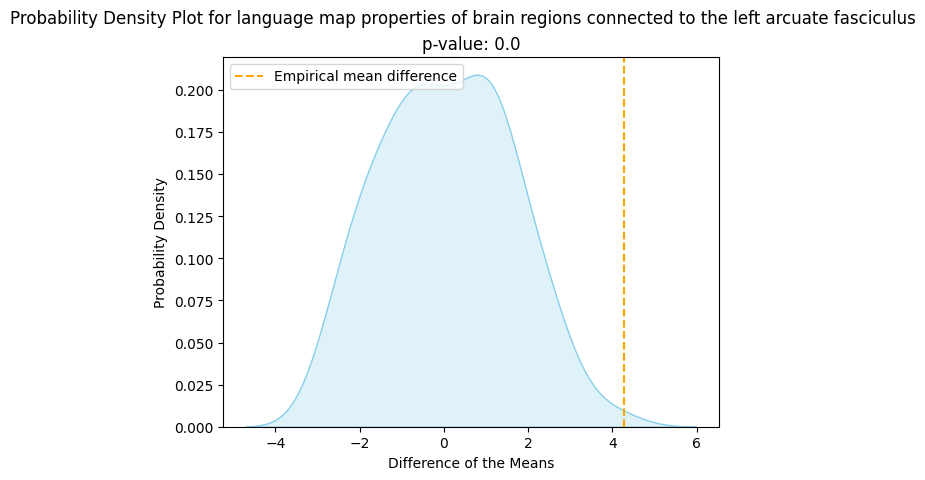

In [6]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Create a probability density plot using KDE
sns.kdeplot(null_mean_diffs, shade = True, color = 'skyblue')

# Add a vertical line at the empirical mean difference (i.e. for the non-rotated original map)
plt.axvline(x = empirical_mean_diff, color = 'orange', linestyle='--', label = 'Empirical mean difference')

# Add labels and title
plt.xlabel('Difference of the Means')
plt.ylabel('Probability Density')
plt.suptitle(f'Probability Density Plot for {case_map} map properties of brain regions connected to the left arcuate fasciculus')
plt.title(f'p-value: {round(empirical_p_value, 3)}')
plt.legend()

# Show the plot
plt.show()

Note that the map values (myelin, in this case) have been standardized. 

#### Tract similarity across all tracts and all maps

Now, let's do the same test but for all tracts and plot this - once collapsed across all tracts, and once as a grid displaying results per tract. 
We'll do this for every map we want to look at: S-A axis, cortical thickness, myelin and the first FC gradient.

In [12]:
import importlib
importlib.reload(tractmaps_utils)

<module 'tractmaps_utils' from '/Users/joelleba/neurohackademy/tractmaps/tractmaps_utils.py'>

In [ ]:
# define white matter tracts to loop over 
tracts = data.filter(regex='left|right').columns

# remove the fornix ("F_") as this tract is connected to only 1 region (the hippocampus) and thus results in NA for the t-test
tracts = tracts[~tracts.isin(['F_left', 'F_right'])]

# define number of spins
nspins = 10000

# compute_nulls (from tractmaps_utils)
glasser = tractmaps_utils.get_glasser() # load glasser parcellation GIFTI images (lh, rh)
null_map_dict = tractmaps_utils.compute_nulls(maps_list = maps_list, 
                                              tracts = tracts, 
                                              map_names = map_names, 
                                              data = data, 
                                              parcellation = glasser,
                                              nspins = nspins
                                        )

Running nulls for attention...


In [9]:
# compute empirical results (from tractmaps_utils)
result_df = tractmaps_utils.compute_empirical(maps_list = maps_list, 
                                              tracts = tracts, 
                                              map_names = map_names, 
                                              data = data, 
                                              nulls = null_map_dict,
                                              nspins = nspins,
                                              analysis = analysis
                                             )

Running empirical testing for cbv_glasser...
Running empirical testing for areal_scale_glasser...
Running empirical testing for fc_pc1_glasser...
Running empirical testing for evo_expansion_glasser...
Running empirical testing for glu_metab_glasser...
Running empirical testing for meg_alpha_glasser...
Running empirical testing for meg_beta_glasser...
Running empirical testing for meg_delta_glasser...
Running empirical testing for meg_high_gamma_glasser...
Running empirical testing for meg_timescale_glasser...
Running empirical testing for meg_low_gamma_glasser...
Running empirical testing for meg_theta_glasser...
Running empirical testing for thickness_glasser...
Running empirical testing for myelin_glasser...
Running empirical testing for genes_glasser...
Running empirical testing for pet_gaba_glasser...
Running empirical testing for pet_5ht1a_glasser...
Running empirical testing for pet_5h14_glasser...
Running empirical testing for pet_d1_glasser...
Running empirical testing for pet_

In [10]:
result_df # [result_df['map_name'] == 'thickness_glasser']

,tract_name,tract_size,connected_mean,unconnected_mean,empirical_t_statistic,empirical_mean_diff,empirical_effect_size,empirical_p_val,spin_p_val,map_name,fdr_spin_p_val
0,FAT_left,11,-0.389,-0.004,-1.266,-0.385,-0.392,0.207,0.519,cbv_glasser,0.962697
1,AF_left,20,-0.017,-0.029,0.051,0.012,0.012,0.960,0.991,cbv_glasser,0.998631
2,PTAT_left,10,0.045,-0.032,0.239,0.076,0.077,0.811,0.909,cbv_glasser,0.984321
3,MdLF_left,9,0.434,-0.052,1.454,0.485,0.495,0.148,0.505,cbv_glasser,0.962697
4,SLF_III_left,13,-0.313,-0.005,-1.093,-0.308,-0.314,0.276,0.640,cbv_glasser,0.965638
...,...,...,...,...,...,...,...,...,...,...,...
1095,CStr_S_right,16,-0.399,0.043,-1.697,-0.442,-0.443,0.091,0.501,sa_axis_glasser,0.962697
1096,CTh_A_right,12,1.297,-0.088,4.933,1.385,1.468,0.000,0.046,sa_axis_glasser,0.585106
1097,CTh_P_right,7,-1.089,0.048,-3.020,-1.138,-1.159,0.003,0.204,sa_axis_glasser,0.829044
1098,CTh_S_right,8,-0.123,0.010,-0.366,-0.133,-0.132,0.715,0.914,sa_axis_glasser,0.984321


In [11]:
# Now, you can access the null DataFrames for each map in null_map_dict
for map_name, null_map_df in null_map_dict.items():
    print(f"Null Data for Map: {map_name}, dimensions: {null_map_df.shape}")
#     print(null_map_df.head(3))

Null Data for Map: cbv_glasser, dimensions: (500000, 7)
Null Data for Map: areal_scale_glasser, dimensions: (500000, 7)
Null Data for Map: fc_pc1_glasser, dimensions: (500000, 7)
Null Data for Map: evo_expansion_glasser, dimensions: (500000, 7)
Null Data for Map: glu_metab_glasser, dimensions: (500000, 7)
Null Data for Map: meg_alpha_glasser, dimensions: (500000, 7)
Null Data for Map: meg_beta_glasser, dimensions: (500000, 7)
Null Data for Map: meg_delta_glasser, dimensions: (500000, 7)
Null Data for Map: meg_high_gamma_glasser, dimensions: (500000, 7)
Null Data for Map: meg_timescale_glasser, dimensions: (500000, 7)
Null Data for Map: meg_low_gamma_glasser, dimensions: (500000, 7)
Null Data for Map: meg_theta_glasser, dimensions: (500000, 7)
Null Data for Map: thickness_glasser, dimensions: (500000, 7)
Null Data for Map: myelin_glasser, dimensions: (500000, 7)
Null Data for Map: genes_glasser, dimensions: (500000, 7)
Null Data for Map: pet_gaba_glasser, dimensions: (500000, 7)
Null Da

##### Does tract size (nb of connected regions) impact results?

Entire Dataset:
p-value for tract_size: 0.0001


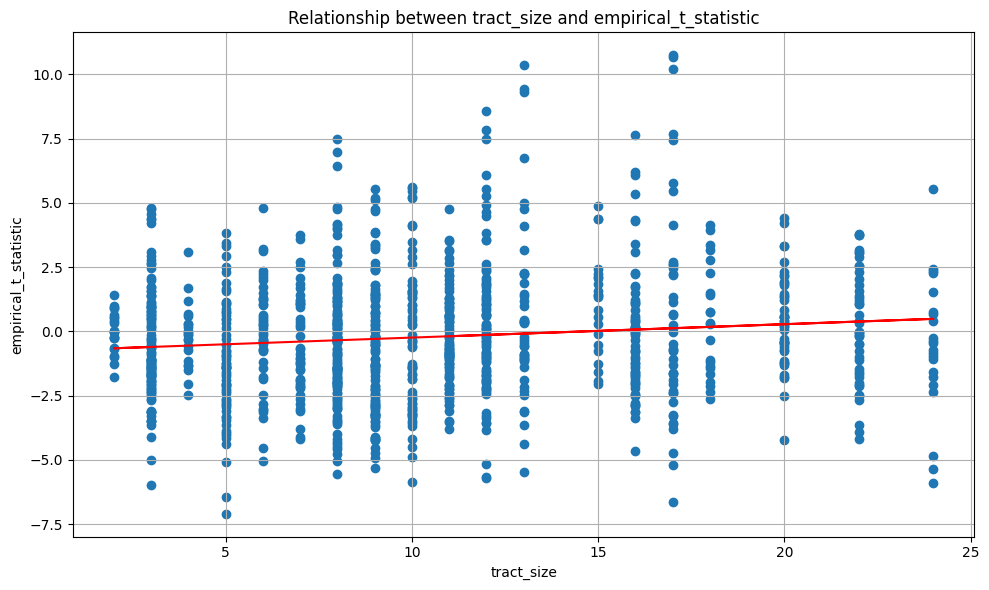

In [12]:
# across maps
tractmaps_utils.run_linear_regression(df = result_df, 
                      x = 'tract_size', 
                      y = 'empirical_t_statistic', 
                      plot = True)

# # show by group
# tractmaps_utils.run_linear_regression(df = result_df, 
#                       x = 'tract_size', 
#                       y = 'empirical_t_statistic', 
#                       separate_by_group = True, 
#                       group_column = 'map_name', 
#                       plot = True)

#### Visualize results

Now that we've tested for statistical significance, we can visualize the results in a couple of different ways: 

* Heatmaps: 
    + Heat map showing the mean cortical property value in structurally connected brain regions
    + Heat map showing the differences between structurally connected and non-connected brain regions (of the same hemisphere)
    + Heat map showing the effect size (t-value) of the differences between structurally connected and non-connected brain regions (of the same hemisphere)
    
   
* Cortical surface maps of structurally connected brain regions (showing the 4-5 maps that are most distinct to a given tract)
* Individual tract & map t-test results and corresponding null distribution plots


##### Heatmaps


In [70]:
import importlib
importlib.reload(tractmaps_utils)

<module 'tractmaps_utils' from '/Users/joelleba/neurohackademy/tractmaps/tractmaps_utils.py'>

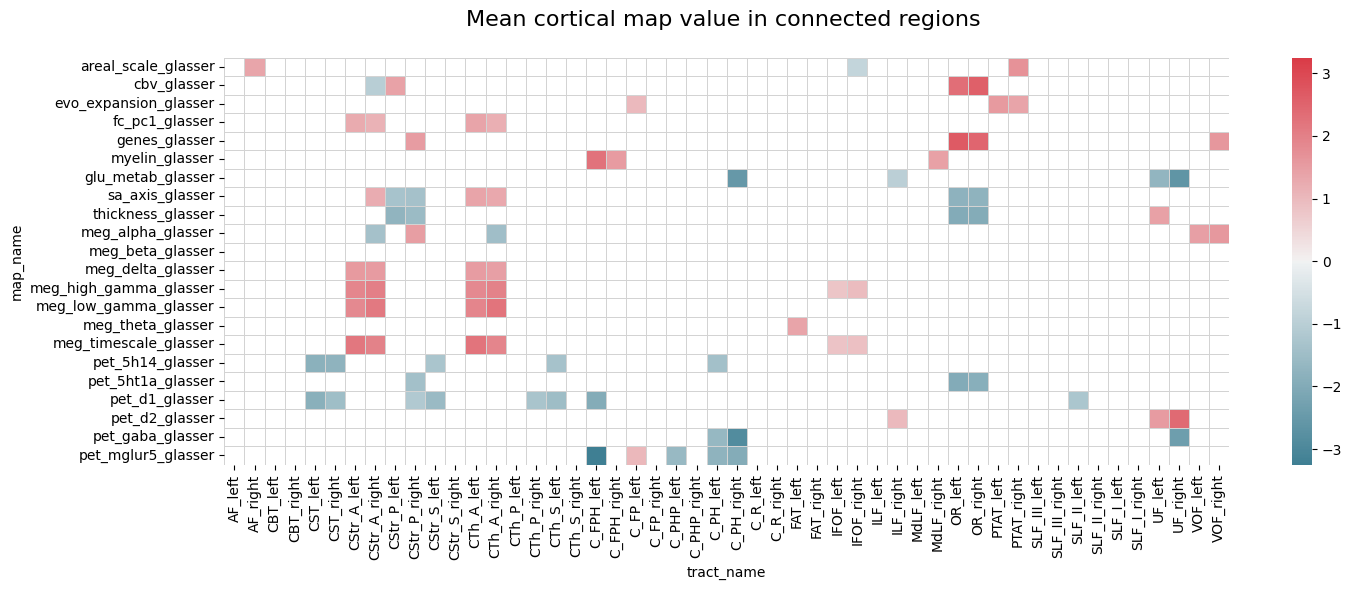

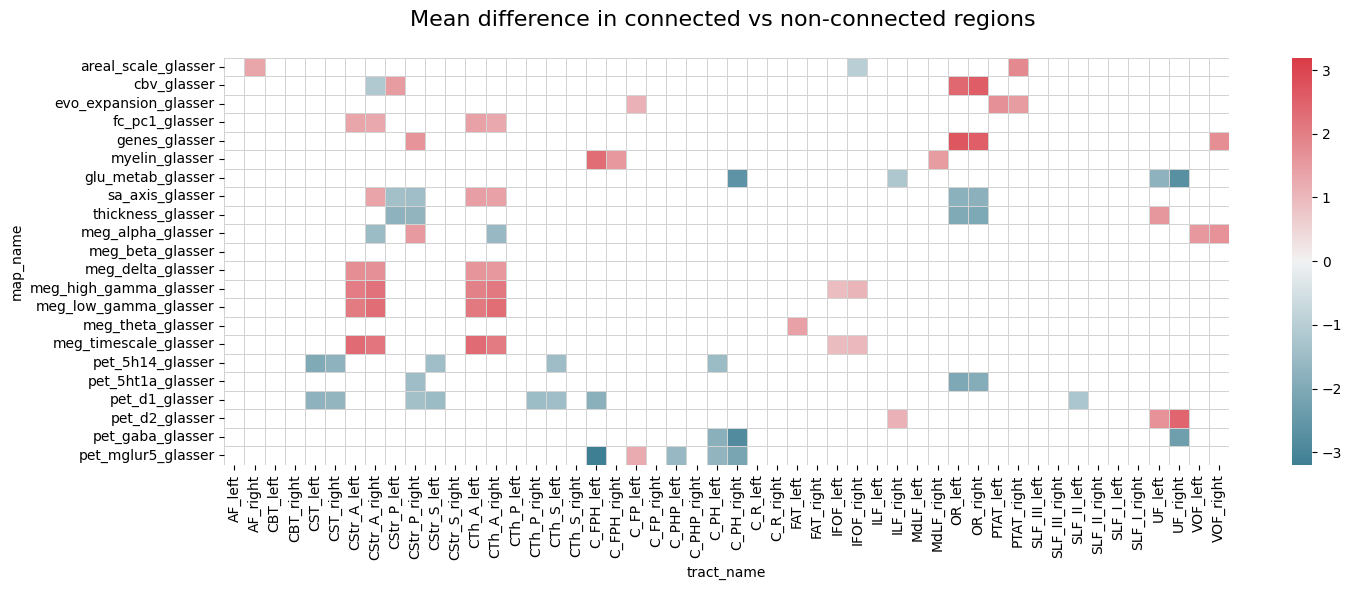

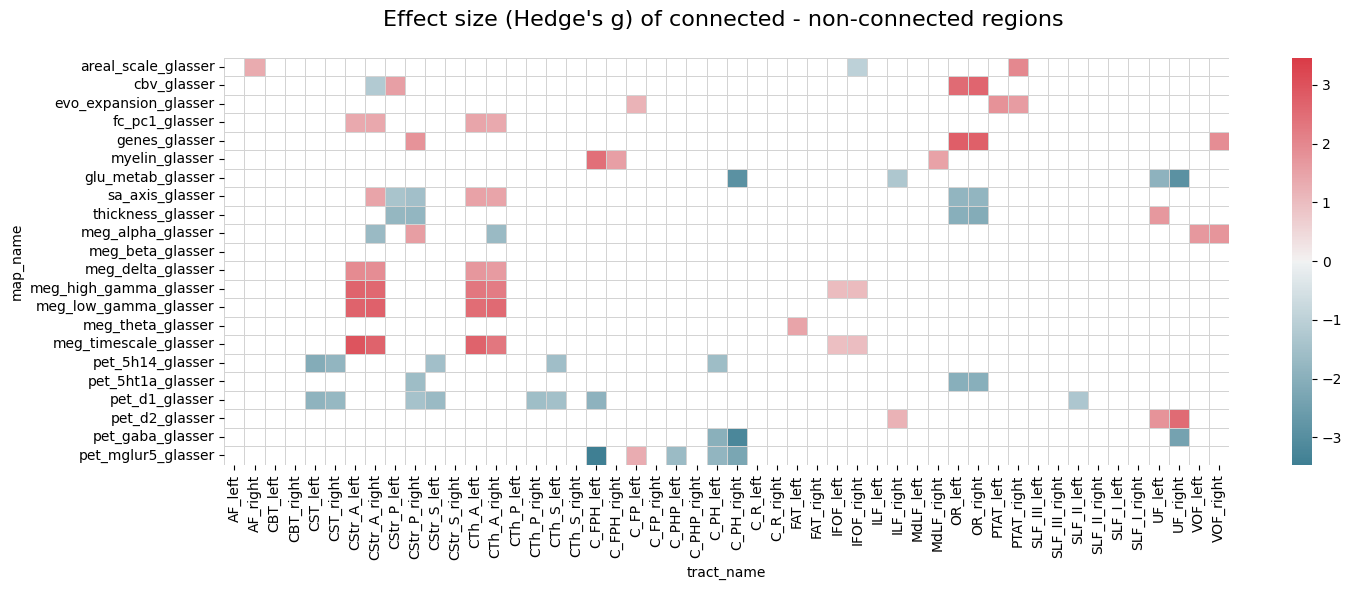

In [71]:
# load results
result_df = pd.read_csv(f'./outputs/ttests_uniqueness/{analysis}_empirical_t_tests.csv')

# define heatmap size
if analysis == 'cortex':
    fig_size = (15, 6)
elif analysis == 'neurosynth':
    fig_size = (13,7)

new_order = np.array(['areal_scale_glasser',
             'cbv_glasser',
             'evo_expansion_glasser',
             'fc_pc1_glasser',
             'genes_glasser',
             'myelin_glasser',
             'glu_metab_glasser',
             'sa_axis_glasser',
             'thickness_glasser',
             'meg_alpha_glasser',
             'meg_beta_glasser',
             'meg_delta_glasser',
             'meg_high_gamma_glasser',
             'meg_low_gamma_glasser',
             'meg_theta_glasser',
             'meg_timescale_glasser',
             'pet_5h14_glasser',
             'pet_5ht1a_glasser',
             'pet_d1_glasser',
             'pet_d2_glasser',
             'pet_gaba_glasser',
             'pet_mglur5_glasser']
            )
    
# mean cortical map value heatmap (generate_heatmap is from tractmaps_utils.py)
tractmaps_utils.generate_heatmap(df = result_df, 
                 brain_maps_col = 'map_name', 
                 tracts_col = 'tract_name', 
                 result_value_col = 'connected_mean', 
                 p_value_col = 'empirical_p_val', 
                 spin_pval_col = 'spin_p_val',
                 row_order = new_order,
                 fdr = True,
                 title = "Mean cortical map value in connected regions \n",
                 outpath = f'./outputs/ttests_uniqueness/{analysis}_uniqueness_meanvals.svg',
                 fig_size = fig_size
                )

# mean difference heatmap (generate_heatmap is from tractmaps_utils.py)
tractmaps_utils.generate_heatmap(df = result_df, 
                 brain_maps_col = 'map_name', 
                 tracts_col = 'tract_name', 
                 result_value_col = 'empirical_mean_diff', 
                 p_value_col = 'empirical_p_val', 
                 spin_pval_col = 'spin_p_val',
                 row_order = new_order,
                 fdr = True,
                 title = "Mean difference in connected vs non-connected regions \n",
                 outpath = f'./outputs/ttests_uniqueness/{analysis}_uniqueness_meandiffs.svg',
                 fig_size = fig_size
                )

# effect size heatmap (generate_heatmap is from tractmaps_utils.py)
tractmaps_utils.generate_heatmap(df = result_df, 
                 brain_maps_col = 'map_name', 
                 tracts_col = 'tract_name', 
                 result_value_col = 'empirical_effect_size', 
                 p_value_col = 'empirical_p_val', 
                 spin_pval_col = 'spin_p_val',
                 row_order = new_order,
                 fdr = True,
                 title = "Effect size (Hedge's g) of connected - non-connected regions \n",
                 outpath = f'./outputs/ttests_uniqueness/{analysis}_uniqueness_effsizes.svg',
                 fig_size = fig_size
                )

##### Tract-based query

Here, we're interested to know: what cortical maps are most strongly associated with a given tract?

To answer this question, we are sorting effect sizes (t-values) across all cortical maps. Then, we select the 3 cortical maps with the largest effect sizes (positive or negative), and display the map values in structurally connected regions, as well as the empirical result and null distribution.

Let's say we're interested in the right Corticostriatal Tract, Anterior Segment (CStr_A_right), as it's showing some pretty strong effect sizes.

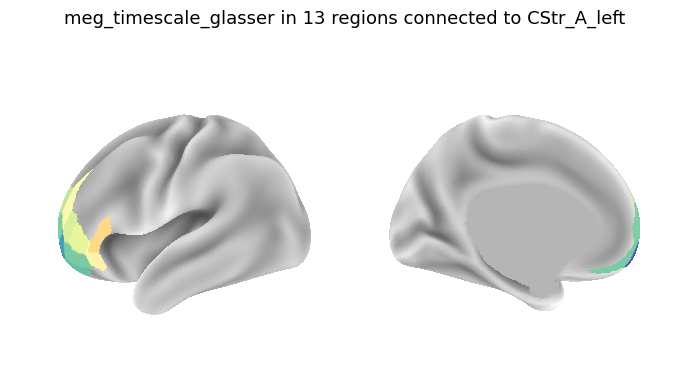

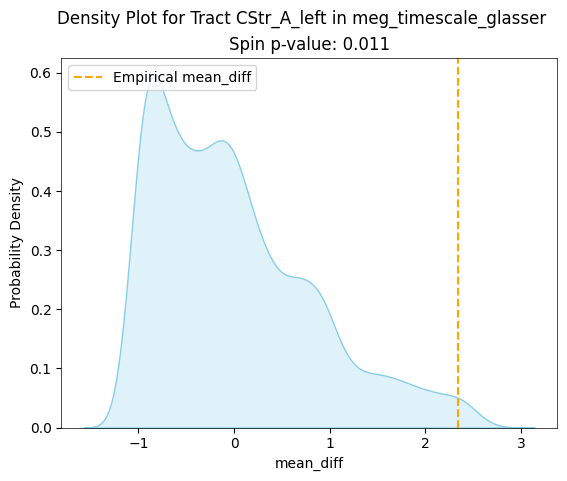

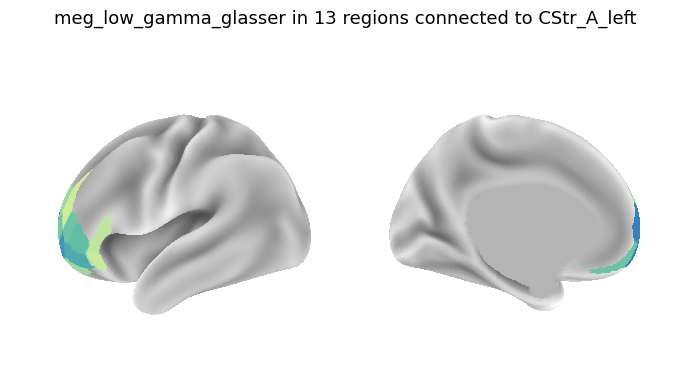

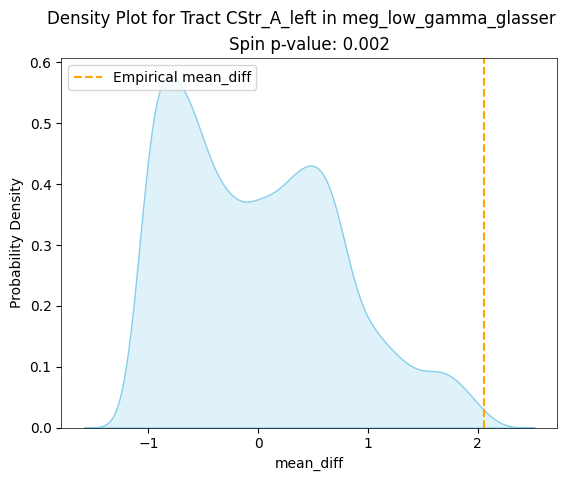

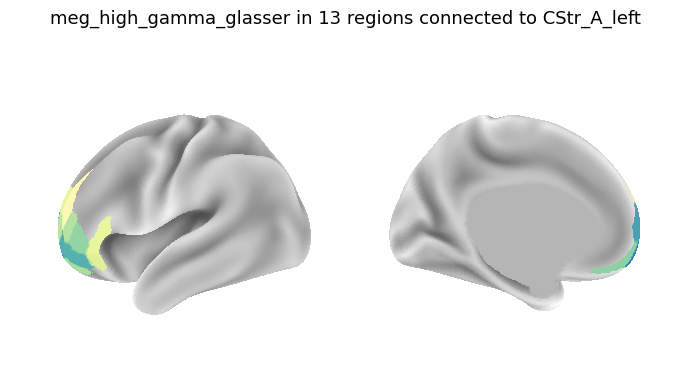

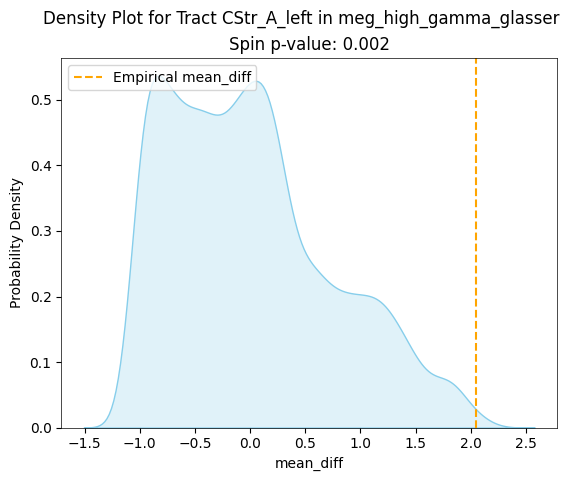

In [19]:
# tract of interest
# tract = 'OR_left'
tract = 'CStr_A_left'

# subset results for this tract
tract_results = result_df[result_df['tract_name'] == tract]

# select 3 cortical maps with the largest effect sizes (regardless of sign)
tract_results['absolute_effect_size'] = tract_results['empirical_effect_size'].abs()
tract_results = tract_results.sort_values(by = 'absolute_effect_size', ascending = False)

# Select the top 3 rows (3 largest absolute values)
top_3_largest = tract_results.head(3)

# create list of brain maps 
maps_to_plot = top_3_largest['map_name'].tolist()


# generate brain surface plot and empirical result & null distribution
for mp in maps_to_plot:
    
    # brain map
    tractmaps_utils.plot_parc_subset(brain_map = glasser_maps[mp],
                                    tracts = tract,
                                    connection_threshold = 0.95,
                                    map_name = mp,
                                    tract_names = tract,
                                    colors = 'Spectral',
                                    mode = 'static')
    
    # plot the null distribution and empirical value of tracts & maps of interest
    tractmaps_utils.plot_density(map_name = mp, 
                                 tract = tract, 
                                 result_value = 'mean_diff', 
                                 density_color = 'skyblue',
                                 analysis = analysis)



##### Cortical map-based query

Here, we're interested to know: what tracts are most strongly associated with a given cortical map?

To answer this question, we are sorting effect sizes (t-values) across all tracts for that specific map. Then, we select the 3 tracts with the largest effect sizes (positive or negative), and display the map values in structurally connected regions, as well as the empirical result and null distribution.

Let's say we're interested in the cortical thickness map.

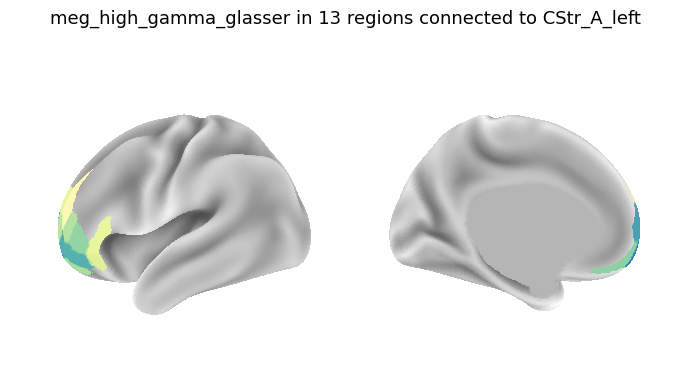

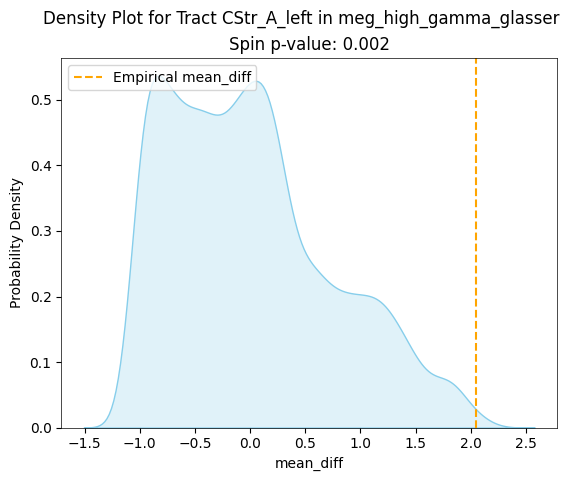

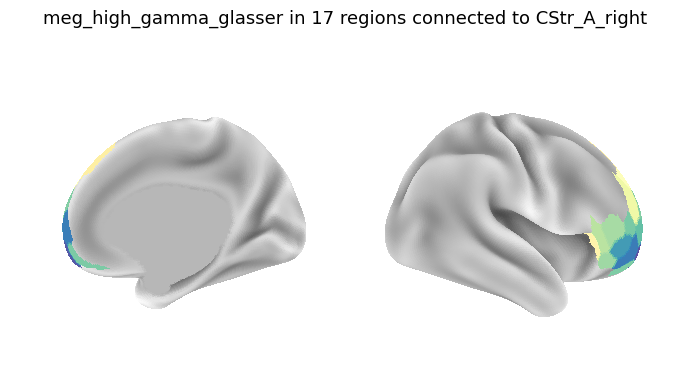

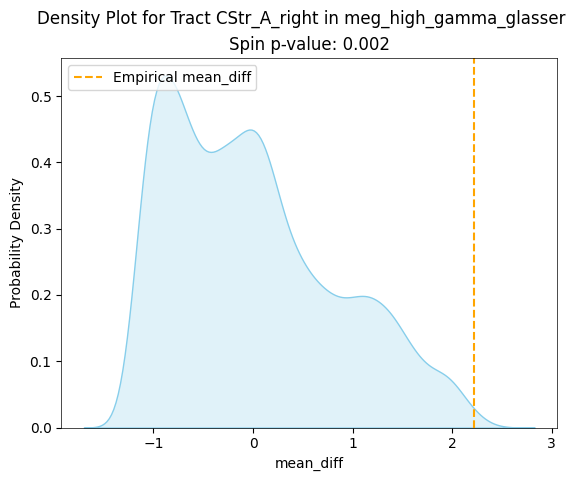

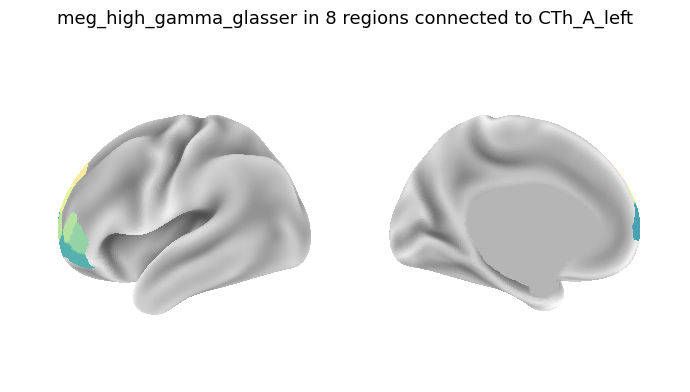

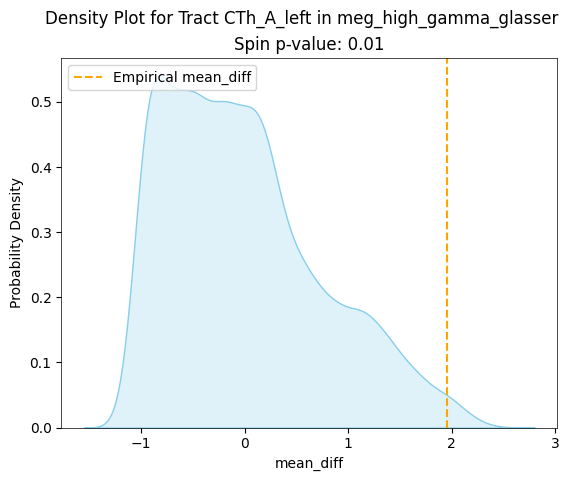

In [20]:
# tract of interest
# brain_map = 'pet_mglur5_glasser'
brain_map = 'meg_high_gamma_glasser'
# brain_map = 'memory_retrieval'

# subset results for this tract
tract_results = result_df[result_df['map_name'] == f'{brain_map}']

# select 3 tracts with the largest effect sizes (regardless of sign)
tract_results['absolute_effect_size'] = tract_results['empirical_effect_size'].abs()
tract_results = tract_results.sort_values(by = 'absolute_effect_size', ascending = False)

# Select the top 3 rows (3 largest absolute values)
top_3_largest = tract_results.head(3)

# create list of brain maps 
tracts_to_plot = top_3_largest['tract_name'].tolist()

# generate brain surface plot and empirical result & null distribution
for tract in tracts_to_plot:

    # brain map
    tractmaps_utils.plot_parc_subset(brain_map = glasser_maps[f'{brain_map}'], #locals()[f'{brain_map}_glasser'],
                                    tracts = tract,
                                    connection_threshold = 0.95,
                                    map_name = brain_map,
                                    tract_names = tract,
                                    colors = 'Spectral',
                                    mode = 'static')
    
    # plot the null distribution and empirical value of tracts & maps of interest
    tractmaps_utils.plot_density(map_name = brain_map, 
                                 tract = tract, 
                                 result_value = 'mean_diff', 
                                 density_color = 'skyblue',
                                 analysis = analysis)



### 3.2. Surface-based tract profiles

Here, the idea is to describe the cortical properties associated with a tract-of-interest. We'll use the superior longitudinal fasciculus (SLF II) as an example.

In [28]:
import importlib
importlib.reload(tractmaps_utils)

<module 'tractmaps_utils' from '/Users/joelleba/neurohackademy/tractmaps/tractmaps_utils.py'>

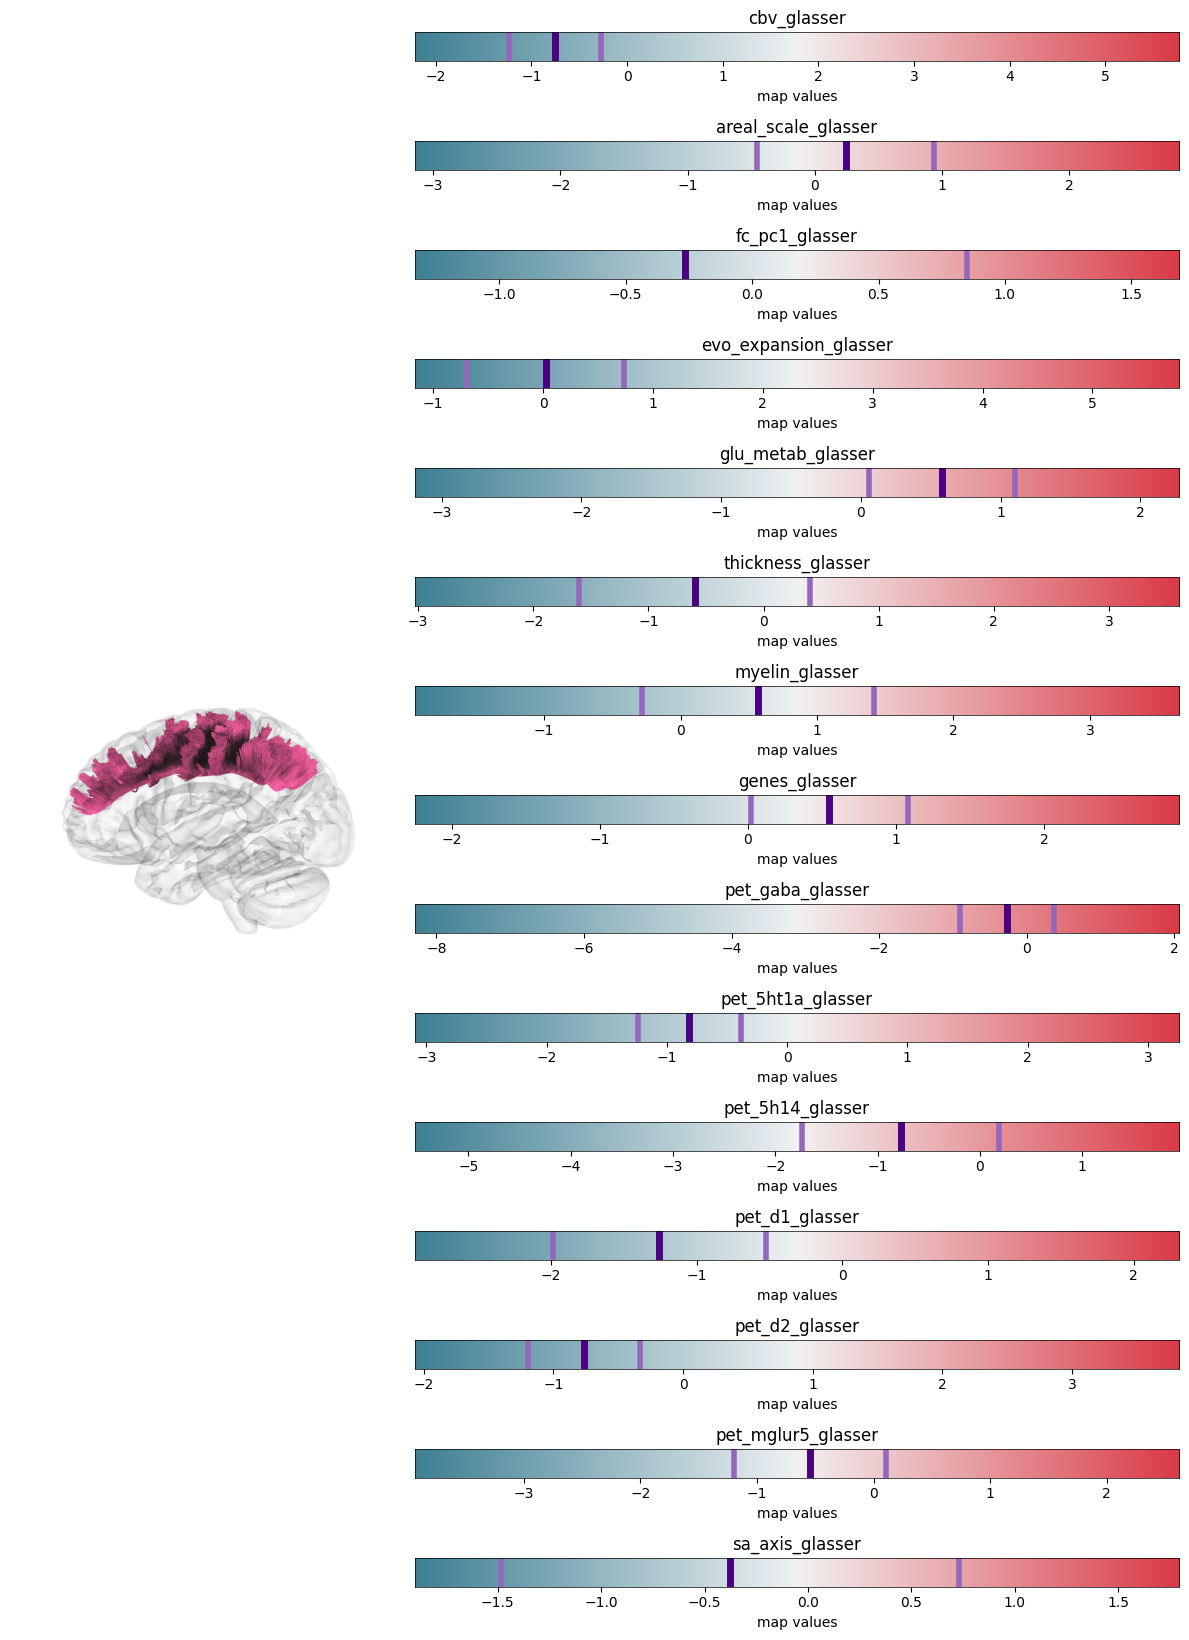

In [22]:
# define a custom colormap
custom_colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
# gradient bars (from tractmaps_utils.py)
tractmaps_utils.create_gradient_bar(tract = 'SLF_II_left', maps_list = maps_list, map_names = map_names, data = data, colormap = custom_colormap)

In [23]:
result_df[result_df['tract_name'] == 'SLF_II_left']

,tract_name,tract_size,connected_mean,unconnected_mean,empirical_t_statistic,empirical_mean_diff,empirical_effect_size,empirical_p_val,spin_p_val,map_name,fdr_spin_p_val
5,SLF_II_left,17,-0.752,0.048,-3.293,-0.800,-0.836,0.001,0.173,cbv_glasser,0.772189
55,SLF_II_left,17,0.243,-0.084,1.329,0.327,0.337,0.186,0.580,areal_scale_glasser,0.949170
105,SLF_II_left,17,-0.267,0.067,-1.293,-0.334,-0.328,0.198,0.610,fc_pc1_glasser,0.949170
155,SLF_II_left,17,0.025,-0.039,0.253,0.064,0.064,0.800,0.895,evo_expansion_glasser,0.973404
205,SLF_II_left,17,0.579,-0.101,2.688,0.679,0.682,0.008,0.350,glu_metab_glasser,0.917832
255,SLF_II_left,17,-0.599,0.004,-2.396,-0.603,-0.608,0.018,0.422,thickness_glasser,0.949170
305,SLF_II_left,17,0.568,-0.070,2.590,0.638,0.657,0.010,0.303,myelin_glasser,0.884542
355,SLF_II_left,17,0.549,-0.027,2.225,0.576,0.565,0.027,0.557,genes_glasser,0.949170
405,SLF_II_left,17,-0.273,0.145,-1.665,-0.417,-0.423,0.098,0.567,pet_gaba_glasser,0.949170
455,SLF_II_left,17,-0.812,0.098,-3.556,-0.910,-0.903,0.000,0.236,pet_5ht1a_glasser,0.862319


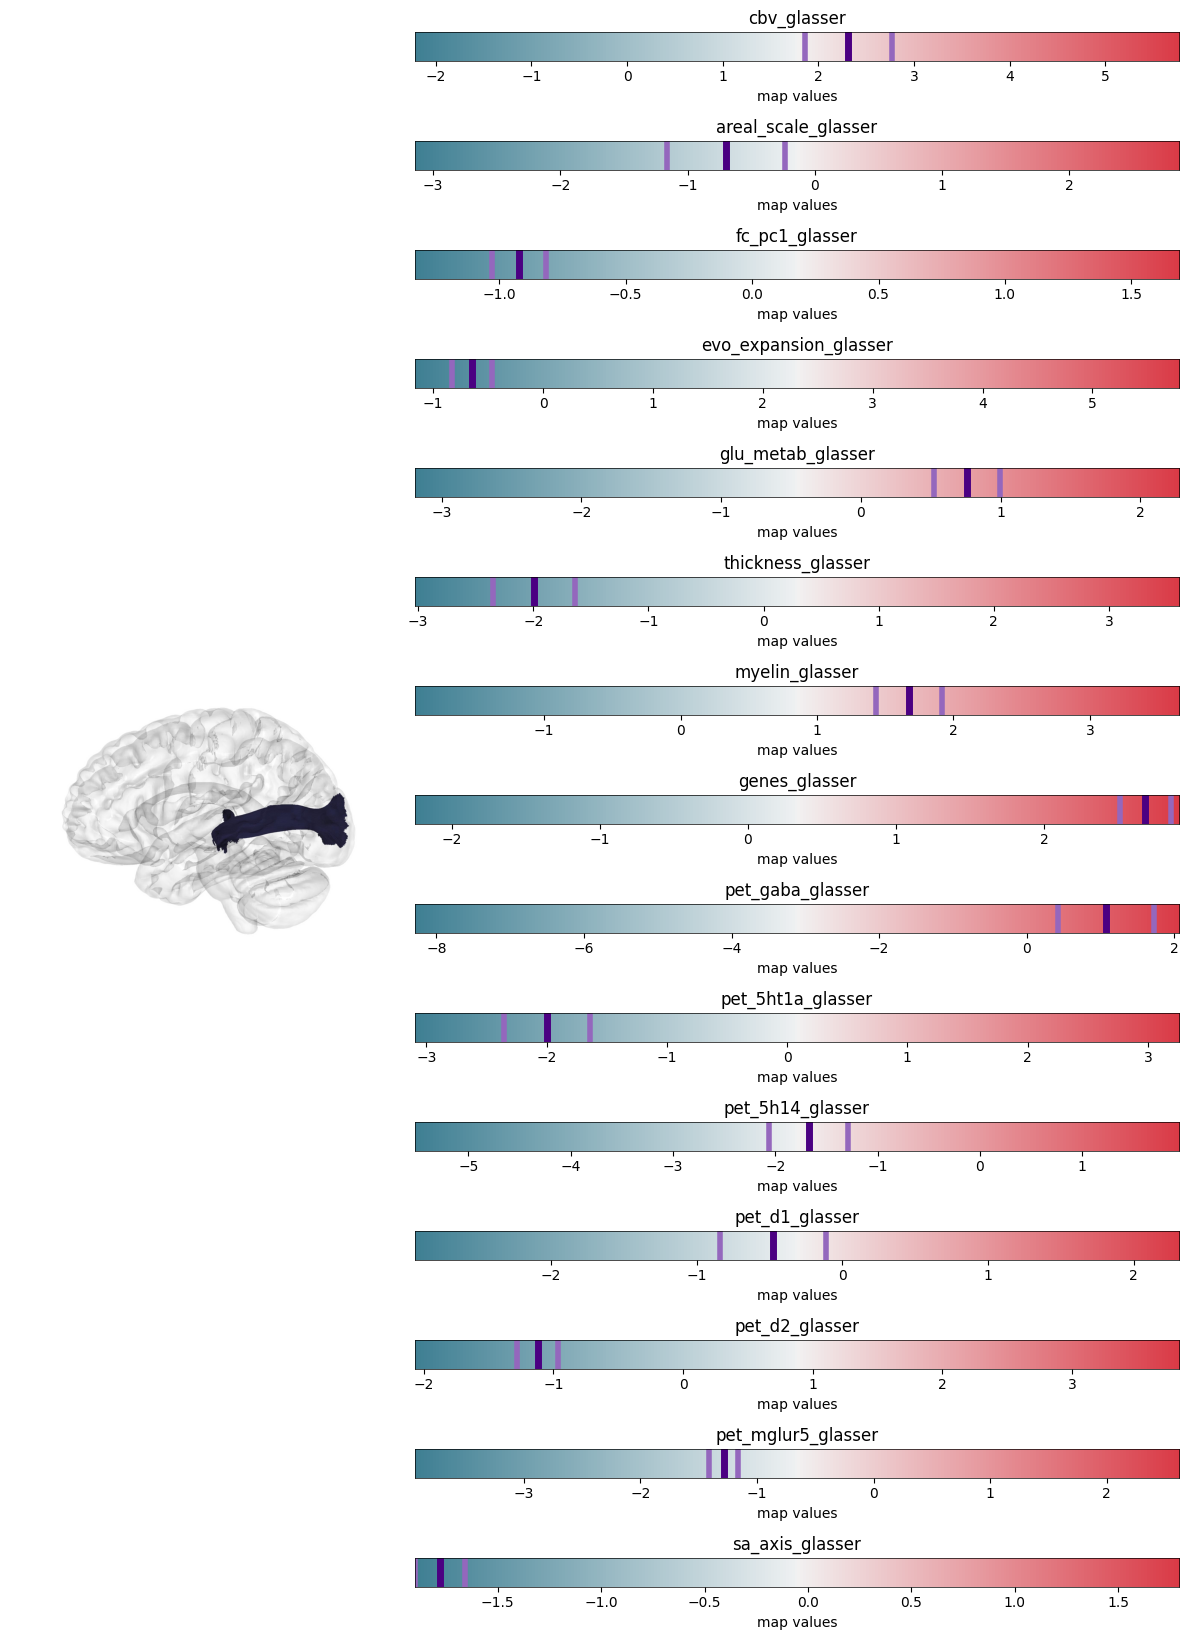

In [24]:
# define a custom colormap
custom_colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
tractmaps_utils.create_gradient_bar(tract = 'OR_left', maps_list = maps_list, map_names = map_names, data = data, colormap = custom_colormap)

In [25]:
result_df[result_df['tract_name'] == 'OR_left']

,tract_name,tract_size,connected_mean,unconnected_mean,empirical_t_statistic,empirical_mean_diff,empirical_effect_size,empirical_p_val,spin_p_val,map_name,fdr_spin_p_val
24,OR_left,3,2.313,-0.067,4.381,2.380,2.540,0.000,0.016,cbv_glasser,0.461538
74,OR_left,3,-0.698,-0.042,-1.168,-0.656,-0.677,0.245,0.511,areal_scale_glasser,0.949170
124,OR_left,3,-0.922,0.052,-1.654,-0.973,-0.959,0.100,0.411,fc_pc1_glasser,0.939787
174,OR_left,3,-0.645,-0.023,-1.073,-0.622,-0.622,0.285,0.357,evo_expansion_glasser,0.923276
224,OR_left,3,0.759,-0.050,1.381,0.809,0.801,0.169,0.353,glu_metab_glasser,0.919271
274,OR_left,3,-1.994,-0.020,-3.497,-1.974,-2.027,0.001,0.033,thickness_glasser,0.551471
324,OR_left,3,1.677,-0.039,3.072,1.716,1.781,0.002,0.063,myelin_glasser,0.615385
374,OR_left,3,2.683,-0.017,4.786,2.700,2.775,0.000,0.004,genes_glasser,0.456522
424,OR_left,3,1.072,0.089,1.719,0.984,0.996,0.087,0.162,pet_gaba_glasser,0.768182
474,OR_left,3,-1.999,0.046,-3.495,-2.045,-2.026,0.001,0.046,pet_5ht1a_glasser,0.551471


## Test tract similarity

In [26]:
from snf import compute

# Get cortical maps names
map_names = list(glasser_maps.keys())
tract_names = list(data.filter(regex = 'left|right').columns)
df = data

# set connection threshold
connection_threshold = 0.95

# generate tract connection masks
tract_masks = {}
for hemisphere in ['Left', 'Right']:
    # select left hemisphere regions and tracts
    if hemisphere == 'Left':
        tracts = df.filter(regex = 'left').columns
        hem_df = df[df['parcel_name'].str.contains('L_')]

    # select right hemisphere regions and tracts    
    elif hemisphere == 'Right':
        tracts = df.filter(regex = 'right').columns
        hem_df = df[df['parcel_name'].str.contains('R_')]
    
    # drop fornix (connected to only 1 region)
    tracts = tracts[~tracts.isin(['F_left', 'F_right'])]
    
    for tract in tracts:
        tract_df = pd.DataFrame(hem_df[tract])
        
        # binarize tract connections based on threshold
        tract_mask_df = tract_df[tract].apply(lambda x: 1 if x >= connection_threshold else 0)
        
        # construct a connectivity matrix (regions connected to tract == 1, rest == 0)
        connectivity_matrix = np.outer(tract_mask_df, tract_mask_df.T)
#         print(pd.DataFrame(connectivity_matrix, index = tract_df.index, columns = tract_df.index))

        # Create a heatmap using seaborn
#         sns.heatmap(connectivity_matrix, cmap='viridis', xticklabels=False, yticklabels=False)
#         plt.show()
        
        # save
        tract_masks[tract] = connectivity_matrix

# generate multimap similarity matrix (regions x regions) for each hemisphere
hem_similarities = {}
for hemisphere in ['Left', 'Right']:
    # select left hemisphere regions and maps
    if hemisphere == 'Left':
        hem_regions = df[df['parcel_name'].str.contains('L_')][map_names].values
    elif hemisphere == 'Right':
        hem_regions = df[df['parcel_name'].str.contains('R_')][map_names].values
        
    # compute affinity matrix
    nnodes = len(hem_regions)
    similarity_matrix = snf.compute.make_affinity(hem_regions,
                                      metric = 'euclidean',
                                      K = np.ceil(nnodes/10).astype(int),
                                      mu = 0.5)

    # save
    hem_similarities[hemisphere] = similarity_matrix
    
# generate spins for each tract connectivity map
# nspins = 1000
# tract_names = list(df_glasser_maps_tracts.filter(regex = 'left|right').columns)
# tract_names = [item for item in tract_names if item not in ['F_left', 'F_right']] # remove fornix (not used below)

# n_tracts = len(tract_names)
# spins_dict = {}

# for tract in range(n_tracts):
#     # select tract connectivity values
#     tract_ = map_names[iMap]

#     # generate spins
#     spins = nulls.alexander_bloch(df[map_name], atlas = 'fsLR', density = '32k', 
#                                          n_perm = nspins, seed = 1234, parcellation = parcellation)

#     # save spins
#     spins_dict[map_name] = spins

    
# compute difference between connected and non-connected for all tracts
result_dfs = []

# compare mean of connected and non-connected regions
for tract_name, tract_mask in tract_masks.items():
    if 'left' in tract_name:
        hem = 'Left'
        similarity_matrix = hem_similarities['Left']
    elif 'right' in tract_name:
        hem = 'Right'
        similarity_matrix = hem_similarities['Right']
    
    # create mask to only select upper triangle region pairs (avoids redundancy in symmetrical matrices)
    nnodes = len(similarity_matrix)
    mask = np.triu(np.ones(nnodes), 1) > 0

    # generate daframe of multimap similarity values in connected vs non-connected regions
    d = dict({'connected' : similarity_matrix[mask][np.where(tract_mask[mask] != 0)],
              'not connected' : similarity_matrix[mask][np.where(tract_mask[mask] == 0)]})
    d = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in d.items()]))

    # Calculate mean and standard deviation
    connected_mean = d['connected'].mean()
    connected_std = d['connected'].std()
    not_connected_mean = d['not connected'].mean()
    not_connected_std = d['not connected'].std()

    # Calculate the empirical statistic
#     emp = connected_mean - not_connected_mean    

    # eventually, significance testing using spins should come here

    # independent t-test (for now just once on empirical data)
    t_stat, p_value = ttest_ind(d['connected'], d['not connected'], nan_policy = 'omit')

    # create results dataframe
    result_df = pd.DataFrame({
        'tract': [tract_name],
        'hemisphere': [hem],
        'connected_mean': [connected_mean],
        'not_connected_mean': [not_connected_mean],
        'connected_std': [connected_std],
        'not_connected_std': [not_connected_std],
        'p_value': p_value
    })

    # Append the dataframe to the list
    result_dfs.append(result_df)
    
    # visualize results
#     fig, axs = plt.subplots()
#     sns.boxplot(data = d)
#     plt.title(f'{tract_name}')
#     plt.show()
    
# Concatenate all DataFrames in the list into a single DataFrame
result_df = pd.concat(result_dfs, ignore_index = True)
result_df

# there are significant differences in the "multimap" similarity values of connected vs non-connected regions for different tracts. However, plots don't look great, 
# the non-connected values are generally lower but have lots of extreme values so they look pretty "smushed".

,tract,hemisphere,connected_mean,not_connected_mean,connected_std,not_connected_std,p_value
0,FAT_left,Left,0.023703,0.009365,0.029279,0.017157,7.112708e-10
1,AF_left,Left,0.018157,0.009309,0.026094,0.017072,1.910207e-12
2,PTAT_left,Left,0.031220,0.009353,0.034198,0.017124,1.737420e-17
3,MdLF_left,Left,0.023655,0.009382,0.030594,0.017178,6.831719e-07
4,SLF_III_left,Left,0.021972,0.009353,0.033882,0.017091,1.073322e-10
5,SLF_II_left,Left,0.023520,0.009294,0.035782,0.016939,7.937258e-22
6,SLF_I_left,Left,0.023015,0.009367,0.030109,0.017154,4.448219e-09
7,C_FP_left,Left,0.029130,0.009284,0.038772,0.016927,4.522627e-32
8,C_R_left,Left,0.026240,0.009376,0.042234,0.017119,4.400602e-09
9,C_FPH_left,Left,0.018380,0.009412,0.012309,0.017232,3.674534e-01


In [123]:
import importlib
importlib.reload(tractmaps_utils)

<module 'tractmaps_utils' from '/Users/joelleba/neurohackademy/tractmaps/tractmaps_utils.py'>

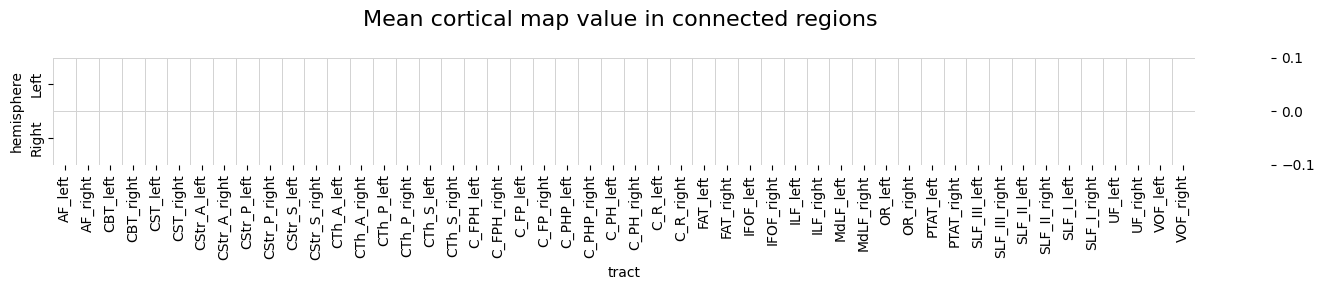

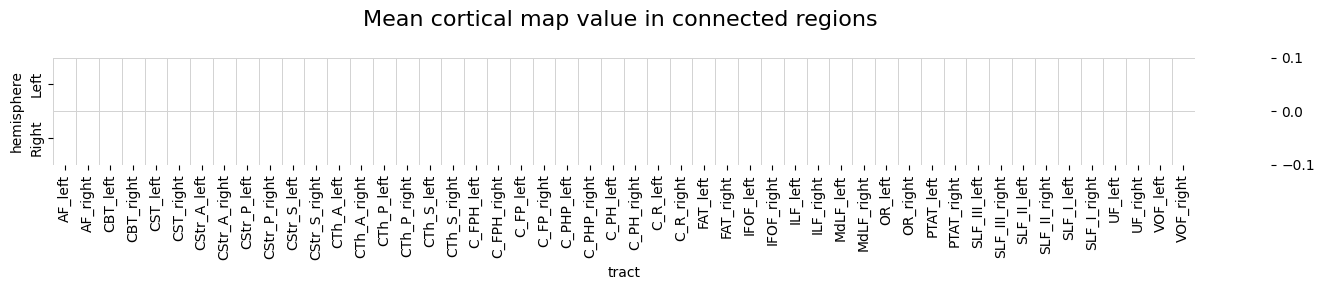

In [27]:
# mean cortical map value heatmap (generate_heatmap is from tractmaps_utils.py)
tractmaps_utils.generate_heatmap(df = result_df, 
                 brain_maps_col = 'hemisphere', 
                 tracts_col = 'tract', 
                 result_value_col = 'connected_mean', 
                 p_value_col = 'p_value', 
                 title = "Mean cortical map value in connected regions \n",
                 outpath = f'./outputs/ttests_similarity/{analysis}_similarity_connected_meanvals.svg',
                 fig_size = (15, 3)
                )

tractmaps_utils.generate_heatmap(df = result_df, 
                 brain_maps_col = 'hemisphere', 
                 tracts_col = 'tract', 
                 result_value_col = 'not_connected_mean', 
                 p_value_col = 'p_value', 
                 title = "Mean cortical map value in connected regions \n",
                 outpath = f'./outputs/ttests_similarity/{analysis}_similarity_not_connected_meanvals.svg',
                 fig_size = (15, 3)
                )
